# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


Prepare:1.import.2.load data,3.get training,test,validation data, 4.visualization, 5.reshape dataset. 6.normalize. 7.add all ones.

In [44]:
# Run some setup code for this notebook.
print("start...")
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print("end...")

start...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
end...


## CIFAR-10 Data Loading and Preprocessing

In [45]:
# Load the raw CIFAR-10 data.
print("start...")
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print("end...")

start...
Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)
end...


start...


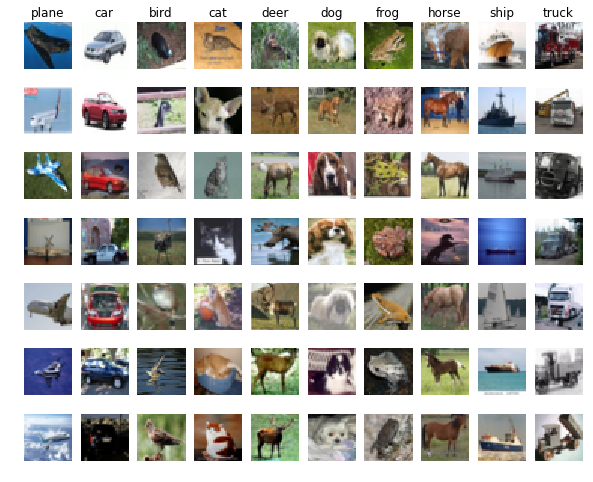

end...


In [46]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
print("start...")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) #np.flatnonzero-->Return indices that are non-zero in the flattened version of a.
    #print("idxs1:",idxs)
    idxs = np.random.choice(idxs, samples_per_class, replace=False) #Generates a random sample from a given 1-D array.(a, size)
    #print("idxs2:",idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
print("end...")

In [47]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
print("start...")
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 1.Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask] #1000 ---->validation
y_val = y_train[mask]

# 2.Our training set will be the first num_train points from the original
# training set.
mask = range(num_training) #49000----->training
X_train = X_train[mask]
y_train = y_train[mask]

# 3.We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False) #500---->development
X_dev = X_train[mask]
y_dev = y_train[mask]

# 4.We use the first num_test points of the original test set as our
# test set.
mask = range(num_test) #1000---->testing
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print("end...")

start...
Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)
end...


In [48]:
# Preprocessing: reshape the image data into rows
print("start...")
X_train = np.reshape(X_train, (X_train.shape[0], -1)) #equal to np.reshape(X_train,(X_train.shape[0],(X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape
print("end...")

start...
Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)
end...


start...
('mean_image.shape:', (3072L,))
[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


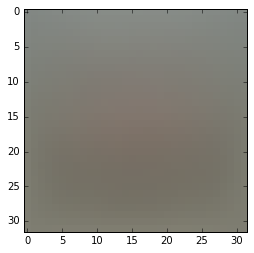

end...


In [49]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
print("start...") #each column is a feature
mean_image = np.mean(X_train, axis=0) #axis=0--->count mean by vertical!(cuizhi)
print("mean_image.shape:",mean_image.shape)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()
print("end...")

In [50]:
# second: subtract the mean image from train and test data
print("start...")
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image
print("end...")

start...
end...


In [51]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
print("start...")
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) #add one of (49000,1)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape
print("end...")

start...
(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)
end...


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [52]:
# Evaluate the naive implementation of the loss we provided for you:
print("start...")
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )
print "grad.shape:",grad.shape
print("end...")

start...
loss: 8.706208
grad.shape: (3073L, 10L)
end...


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [53]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print(".....")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
print("grad.shape:",grad.shape)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -8.549499 analytic: -8.549499, relative error: 3.032367e-11
numerical: -24.368692 analytic: -24.368692, relative error: 1.656394e-12
numerical: 14.261124 analytic: 14.261124, relative error: 1.467067e-11
numerical: -5.025193 analytic: -5.025193, relative error: 2.931636e-11
numerical: -29.601323 analytic: -29.601323, relative error: 1.674850e-11
numerical: -0.439095 analytic: -0.439095, relative error: 5.894399e-10
numerical: -35.700894 analytic: -35.700894, relative error: 9.497848e-12
numerical: -1.813667 analytic: -1.813667, relative error: 5.379793e-11
numerical: 11.507544 analytic: 11.507544, relative error: 1.017386e-11
numerical: -31.101428 analytic: -31.101428, relative error: 3.829901e-12
.....
('grad.shape:', (3073L, 10L))
numerical: 6.115158 analytic: 6.115158, relative error: 5.722611e-12
numerical: -15.897126 analytic: -15.897126, relative error: 7.590549e-13
numerical: -3.756383 analytic: -3.756383, relative error: 1.242850e-11
numerical: -2.803477 analytic: -2

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

yeah. it is possible.may be at some point, loss function is not differentiable.<br/>
one example is: for f(x)=x if x>0;f(x)=-x if x<=0. at point x=0, there has two gradients:0,-1 if you move close to zero from two different direction.and we can not exact say which one is a right single gradient.

In [54]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
print("y_dev.shape:",y_dev.shape)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized) 

Naive loss: 8.706208e+00 computed in 0.134000s
('y_dev.shape:', (500L,))
Vectorized loss: 8.706208e+00 computed in 0.031000s
difference: 0.000000


In [61]:
print("start...")
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)#0.00001 for regularization
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference
print("end...")

start...
Naive loss and gradient: computed in 0.132000s
Vectorized loss and gradient: computed in 0.004000s
difference: 0.000000
end...


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [70]:
print("start...")#--------------------->Remember to add regularization term for both loss function and gradient function
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4, 
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)
print("end...")

start...
iteration 0 / 1500: loss 788.540356
iteration 100 / 1500: loss 289.742833
iteration 200 / 1500: loss 108.493787
iteration 300 / 1500: loss 42.626726
iteration 400 / 1500: loss 19.217190
iteration 500 / 1500: loss 10.296022
iteration 600 / 1500: loss 6.567427
iteration 700 / 1500: loss 5.775949
iteration 800 / 1500: loss 5.546857
iteration 900 / 1500: loss 5.356289
iteration 1000 / 1500: loss 5.495891
iteration 1100 / 1500: loss 5.144280
iteration 1200 / 1500: loss 5.413440
iteration 1300 / 1500: loss 5.736823
iteration 1400 / 1500: loss 5.934479
That took 8.228000s
end...


start...


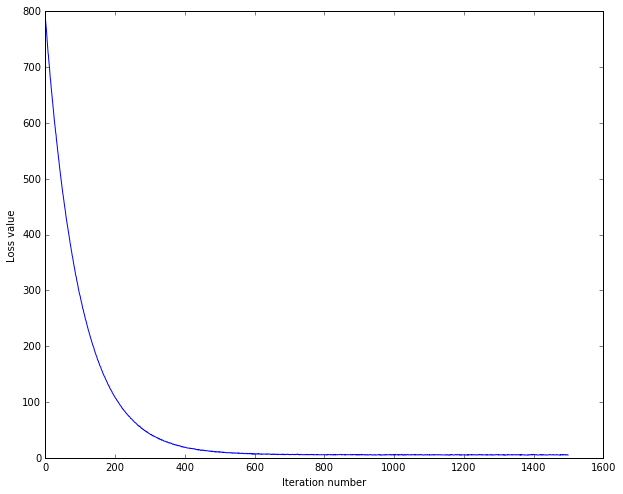

end...


In [71]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
print("start...")
#print("loss_hist.shape:",loss_hist)
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()
print("end...")

In [72]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.366449
validation accuracy: 0.380000


In [82]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates =[1e-8,5e-7,1e-7,1e-6,1e-5,5e-5]#[1e-7, 5e-5] --->Best:lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.397939 val accuracy: 0.400000
regularization_strengths =[5e1,1e2,5e2,1e3,1e4,5e4,1e5,5e5,1e6] #[5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun(turn) the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#pass
for lamda in learning_rates:
    for r in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lamda, reg=r,
                      num_iters=500, verbose=True) #1500-->1000
        #1.predict on training dataset
        y_train_pred=svm.predict(X_train)
        accuracy_train=np.mean(y_train_pred==y_train)
        #2.predict on validatiion dataset
        y_val_pred = svm.predict(X_val)
        accuracy_validation=np.mean(y_val_pred==y_val)
        results[(lamda,r)]=(accuracy_train,accuracy_validation) 
        if accuracy_validation>best_val:
            best_val=accuracy_validation
            best_svm=svm
            #add accuracy on testing set(optional)
            y_test_pred=svm.predict(X_test)
            accuracy_test=np.mean(y_test_pred==y_test)
            print("best_val:"best_val,"accuracy_test:",accuracy_test)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 500: loss 34.747235
iteration 100 / 500: loss 22.644000
iteration 200 / 500: loss 22.136640
iteration 300 / 500: loss 16.637789
iteration 400 / 500: loss 16.039252
('accuracy_test:', 0.152)
iteration 0 / 500: loss 25.654708
iteration 100 / 500: loss 20.966983
iteration 200 / 500: loss 17.060580
iteration 300 / 500: loss 17.366273
iteration 400 / 500: loss 15.163937
('accuracy_test:', 0.17299999999999999)
iteration 0 / 500: loss 30.408852
iteration 100 / 500: loss 26.868790
iteration 200 / 500: loss 23.073166
iteration 300 / 500: loss 21.356398
iteration 400 / 500: loss 21.513274
iteration 0 / 500: loss 36.355597
iteration 100 / 500: loss 30.933019
iteration 200 / 500: loss 29.833224
iteration 300 / 500: loss 28.169299
iteration 400 / 500: loss 28.279371
iteration 0 / 500: loss 173.953778
iteration 100 / 500: loss 165.635546
iteration 200 / 500: loss 160.313293
iteration 300 / 500: loss 157.827008
iteration 400 / 500: loss 151.862277
iteration 0 / 500: loss 800.435714
iter

start...


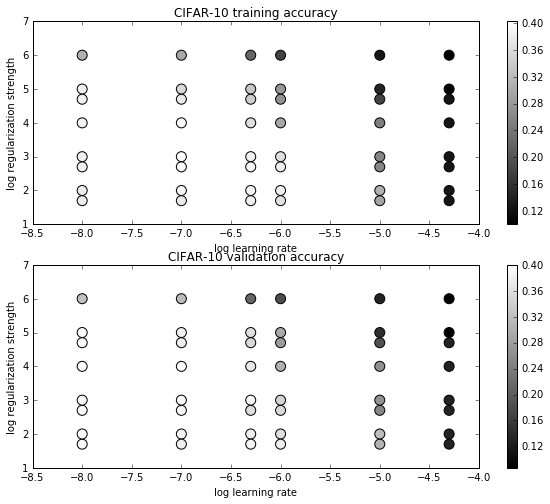

end...


In [74]:
print("start...")
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()
print("end...")

In [84]:
# Evaluate the best svm on test set
print("start...")
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy
print("end...")

start...
linear SVM on raw pixels final test set accuracy: 0.103000
end...


In [88]:
#Using the best learning rate and regularization term to predit on validation set and test set #lr 1.000000e-07 reg 1.000000e+04
lamda=1.000000e-07
r=1.000000e+04
loss_hist = svm.train(X_train, y_train, learning_rate=lamda, reg=r,
                      num_iters=1500, verbose=True) 
#predict on validation set using learned SVM
y_val_pred=svm.predict(X_val)
accuracy_val=np.mean(y_val_pred==y_val)
#predict on test set
y_test_pred=svm.predict(X_test)
accuracy_test=np.mean(y_test_pred==y_test)
print("accuracy_val:",accuracy_val,"accuracy_test:",accuracy_test)

iteration 0 / 1500: loss 175.624530
iteration 100 / 1500: loss 134.679891
iteration 200 / 1500: loss 110.195621
iteration 300 / 1500: loss 89.578026
iteration 400 / 1500: loss 74.021197
iteration 500 / 1500: loss 61.426060
iteration 600 / 1500: loss 50.257024
iteration 700 / 1500: loss 43.020193
iteration 800 / 1500: loss 35.192177
iteration 900 / 1500: loss 29.474782
iteration 1000 / 1500: loss 24.917587
iteration 1100 / 1500: loss 21.004792
iteration 1200 / 1500: loss 17.934578
iteration 1300 / 1500: loss 15.635989
iteration 1400 / 1500: loss 13.506029
('accuracy_val:', 0.38400000000000001, 'accuracy_test:', 0.35499999999999998)


start...
end...


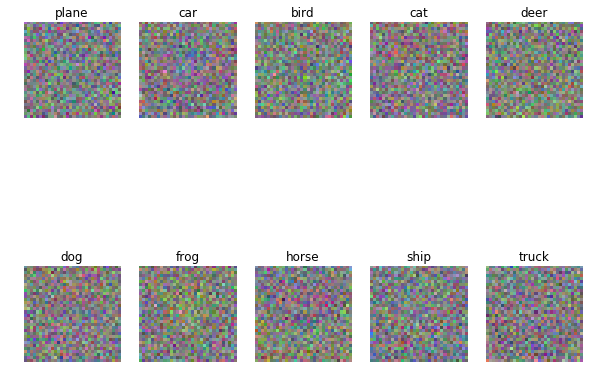

In [89]:
print("start...")
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
print("end...")

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** *fill this in*

In [ ]:
they are spots with different colors for different categories.for example, the car i can see in the middle it seems blue.and for other
categories, colors distributions are different.
i think the reason why it look like this is because that certain category have a common pattern. for example in our dataset, maybe there are
lots of cars with blue colors, and typically cars are in the middle of pictures.